In [107]:
import os

In [2]:
pwd

'/Users/phuongchi/Documents/GLEASON_2019/Gleason-master'

In [3]:
pip install tensorflow==1.15.0


Note: you may need to restart the kernel to use updated packages.


In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [109]:
import tensorflow as tf

In [110]:
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  1.15.0


In [111]:
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
%matplotlib inline
import random
# import re
# from PIL import Image
#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
# import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
# from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.layers import conv2d_transpose
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#from keras.utils import *

In [112]:
DATA_DIR = '/Users/phuongchi/Documents/GLEASON_2019/Gleason-master'

In [113]:
x_train_dir = os.path.join(DATA_DIR, 'train_frames/train')
y_train_dir = os.path.join(DATA_DIR, 'train_masks/train')

x_valid_dir = os.path.join(DATA_DIR, 'val_frames/val')
y_valid_dir = os.path.join(DATA_DIR, 'val_masks/val')

In [114]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

# Data Loading

In [115]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', '1', '2', '3', '4', '5']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
        
        self.masks_fps =[]
        for i in self.image_ids:
            for j in self.mask_ids:
                if i[:-4] == j[0:16]:
                    self.masks_fps.append(os.path.join(masks_dir,j))
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. 0 or 1 or 2)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_ids)
    
    def allItemsToStr(self):
        result = "imgs are " + str(len(self.image_ids)) + " masks " + str(len(self.mask_ids))
        # for each img, result + img path/ name.../ size
        return result
    
    def __str__(self):
        return 'Dataset: len is: ' + str(len(self.image_ids)) + " item summary: " + self.allItemsToStr() 
    
 

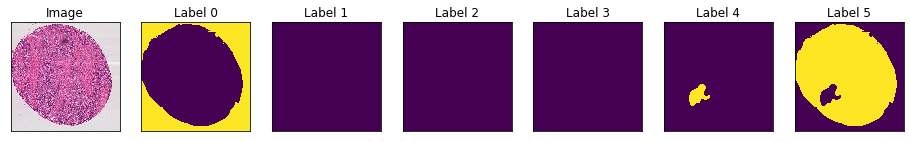

In [116]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0','1','2','3','4','5'])

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    label_0=mask[..., 0].squeeze(),
    label_1=mask[..., 1].squeeze(),
    label_2=mask[..., 2].squeeze(),
    label_3=mask[..., 3].squeeze(),
    label_4=mask[..., 4].squeeze(),
    label_5=mask[..., 5].squeeze()
)

In [98]:
print(dataset)

Dataset: len is: 200 item summary: imgs are 200 masks 200


In [117]:
print(str(image.shape))

(5120, 5120, 3)


In [133]:
class Dataloader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integer number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
        https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/utils/data_utils.py#L444-L454
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
    
    def dataToStr(self,data):
        return "img= " + str(data[0].shape) + " mask= " + str(data[1].shape)
    
    def allDataSetToStr(self):
        result = ''
        for data in self.dataset:
            result + ' ## ' + self.dataToStr(data)
        
        return result
    
    def __str__(self):
        return 'Data loader ' + str(len(self.indexes)) + " batch size " + str(self.batch_size) + " data set " + str(len(self.dataset)) + self.allDataSetToStr()
    
    

# Data Augmentation

Refer to this github 
https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

In [119]:
pip install -U albumentations>=0.3.0 --user

Note: you may need to restart the kernel to use updated packages.


In [15]:
import albumentations as A

In [135]:
# def round_clip_0_1(x, **kwargs):
#     return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [
        
        A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),

        A.HorizontalFlip(p=0.5),
        
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        A.RandomCrop(height=512, width=512, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),
        A.PadIfNeeded(512, 512)
    ]
    return A.Compose(test_transform)

def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=normalize),
    ]
    return A.Compose(_transform)

def normalize(img, max_pixel_value=255.0, **args ):
    mean_img = img.mean()
    std_img = img.std()
    mean = np.array(mean_img, dtype=np.float32)
    mean *= max_pixel_value

    std = np.array(std_img, dtype=np.float32)
    std *= max_pixel_value

    denominator = np.reciprocal(std, dtype=np.float32)

    img = img.astype(np.float32)
    img -= mean
    img *= denominator
    return img

# Segmentation model training

In [121]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

# batch_shape=(512,512,3)
# inputs = Input(batch_shape=(4, 512, 512, 3))
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(6, (1, 1), activation='softmax')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


In [122]:
# define optomizer
optim = tf.keras.optimizers.Adam()


In [123]:
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

In [124]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

In [125]:
loss= tf.keras.losses.CategoricalCrossentropy()

In [126]:
smooth = 1.

In [127]:
model.compile(optim, loss, metrics=[dice_coef,'accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 512, 512, 16) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 16) 2320        dropout_18[0][0]                 
____________________________________________________________________________________________

# SET UP DATA FOR TRAINING

In [128]:
BATCH_SIZE = 8
CLASSES = ['0', '1','2','3','4','5']
LR = 0.0001
EPOCHS = 40
n_classes = len(CLASSES)

In [134]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing()
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing()
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, n_classes)

In [101]:
print(valid_dataloader)

Data loader 44 batch 1 data set 44


In [102]:
valid_dataloader.allDataSetToStr()

''

In [130]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),  
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

In [27]:
#tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',),

In [131]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),verbose =1 
)

Epoch 1/40


InvalidArgumentError: Expected dimension in the range [0, 0), but got -1
	 [[{{node metrics_4/acc/ArgMax}}]]